In [30]:
import cv2
import numpy as np
from skimage import morphology
import matplotlib.pyplot as plt
from keras.models import load_model


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [31]:
def getIntersection(Ia,Ib):
    if Ib[0] > Ia[1] or Ia[0] > Ib[1]:
        return -1
    else:
        Os = max(Ia[0],Ib[0])
        Oe = min(Ia[1],Ib[1])
        return (Os,Oe)

In [32]:
def cropImage(timg,tol=0):
    # Convert to binary
    # (thresh, timg) = cv2.threshold(timg, 127, 255, cv2.THRESH_BINARY)
    #  Crop only ones from binary
    mask = timg>tol
    timg = timg[np.ix_(mask.any(1),mask.any(0))]
    # Add padding to the image
    timg = np.pad(timg, pad_width=round(timg.shape[0]*0.1),mode='constant',constant_values = 0)
    timg = timg.astype(np.uint8)
    # Resize the image to 200*200 pixels
    timg = cv2.resize(timg, (28,28), interpolation = cv2.INTER_AREA)
    timg[timg > 0] = 255
    # timg = cv2.blur(timg,(25,25))
    return timg


In [33]:
def drawLines(img, lines):
    img = np.zeros_like(img)
    for r,theta in lines[0]:
    
        # Stores the value of cos(theta) in a
        a = np.cos(theta)
    
        # Stores the value of sin(theta) in b
        b = np.sin(theta)
        
        # x0 stores the value rcos(theta)
        x0 = a*r
        
        # y0 stores the value rsin(theta)
        y0 = b*r
        
        # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
        x1 = int(x0 + 1000*(-b))
        
        # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
        y1 = int(y0 + 1000*(a))
    
        # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
        x2 = int(x0 - 1000*(-b))
        
        # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
        y2 = int(y0 - 1000*(a))
        
        # cv2.line draws a line in img from the point(x1,y1) to (x2,y2).
        # (0,0,255) denotes the colour of the line to be 
        #drawn. In this case, it is red. 
        cv2.line(img,(x1,y1), (x2,y2), (0,0,255),2)
    return img[:,:,2]

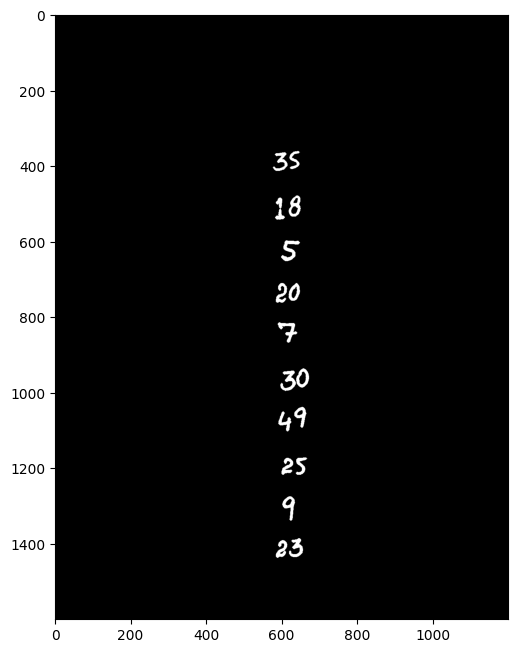

In [34]:
def processImage(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    rimg,gimg,bimg = cv2.split(img)
    hsvimg = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    h,s,v = cv2.split(hsvimg)


    grayImg = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    bw = cv2.adaptiveThreshold(grayImg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
    # grayImg[grayImg<150] = 255
    # grayImg[grayImg>150] = 0
    # return grayImg

    u_red = np.array([255,100,100])
    l_red = np.array([100,0,0])
    mask = cv2.inRange(img,l_red,u_red)
    blur = cv2.medianBlur(mask,3)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(13,13))
    dilation = cv2.dilate(blur,kernel,1)



    # rmimg = morphology.remove_small_objects(dilation.astype(bool),min_size=250,connectivity=2).astype(np.uint8)*255
    # arr = np.nonzero(rmimg)
    # l_range = arr[1].min()
    # h_range = arr[1].max()

    arr = np.nonzero(dilation)
    unique,counts = np.unique(arr[1],return_counts=True)
    center = unique[np.argmax(counts == counts.max())]
    l_range = center - 50
    h_range = center + 50

    blur[:,:] = 0
    blur[:,l_range:h_range] = 255
    s[s>50]= 255
    outimg = cv2.bitwise_and(blur,s)
    outimg[outimg< 127] = 0



    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    outimg = cv2.dilate(outimg,kernel,1)


    return outimg

img = cv2.imread('data/0.jpeg')
pimg = processImage(img)
plt.imshow(pimg,'gray')

In [35]:
# img,labels,stats,centroids = cv2.connectedComponentsWithStats(img)
# labels = cv2.connectedComponentsWithStats(img)

_, thresh = cv2.threshold(pimg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
connectivity = 8  # You need to choose 4 or 8 for connectivity type
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh , connectivity , cv2.CV_32S)

In [36]:
e_labels= []
for i in range(1,len(centroids)):
    oneLabel = np.zeros_like(labels)
    oneLabel[labels==i]=255
    oneLabel = cropImage(oneLabel)
    oneLabel = oneLabel.reshape((28,28,1))
    e_labels.append(oneLabel)
    # print(oneLabel.shape)

    # obj = lambda: None
    # obj.center = centroids[i]
    # obj.pred = 
    # e_data[i] = obj


In [37]:
# imgs = np.expand_dims(e_labels,axis=0)
classifier = load_model("final_model.h5")
imgs = np.array(e_labels)
preds = np.argmax(classifier.predict(imgs),axis=-1)
preds = np.insert(preds,0,-1,axis=0)

In [38]:
e_data = {}
for i in range(1,len(centroids)):
    obj = lambda: None
    obj.center = centroids[i]
    obj.pred = preds[i]
    obj.stats = stats[i]
    obj.range = sorted([stats[i][1],stats[i][1]+stats[i][3]])
    obj.column = stats[i][0]
    e_data[i] = obj

In [39]:
numbers = []
check_arr = [True] * len(e_data.values())
for indi,i in enumerate(e_data.values()):
    temp = []
    temp.append(i)
    if check_arr[indi]:
        for indj,j in enumerate(e_data.values()):
            if i != j:
                res = getIntersection(i.range,j.range)
                if res != -1:
                    temp.append(j)
                    check_arr[indj] = False
        check_arr[indi] = False
        numbers.append(temp)

# Result

[35, 18, 5, 20, 7, 30, 49, 25, 9, 23]
221


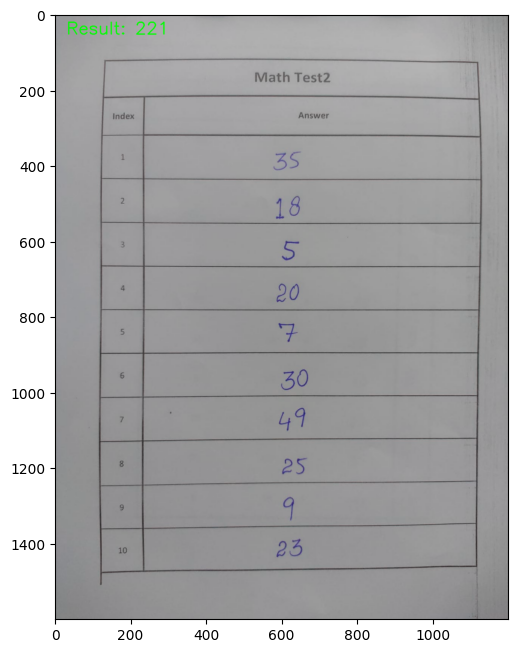

In [40]:
c_numbers = []
for i in numbers:
    size = len(i)
    temp = i
    temp.sort(key=lambda x: x.column)
    num =int(''.join([str(i[k].pred) for k in range(size)]))
    c_numbers.append(num)
result = sum(c_numbers)
print(c_numbers)
print(result)
cv2.putText(img,f"Result: {result}",(30,50),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,255,0),2,cv2.LINE_AA,False)
# plt.imshow(img)
    

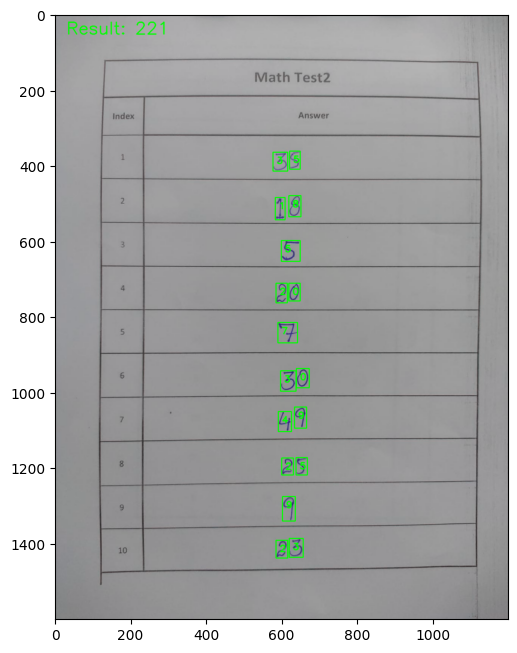

In [41]:
for obj in e_data.values():
    x,y,w,h = (obj.stats[0],obj.stats[1],obj.stats[0]+obj.stats[2],obj.stats[1]+obj.stats[3])
    cv2.rectangle(img,(x,y),(w,h),(0,255,0),2)
    cv2.putText(img,f"{obj.pred}",(x+10,y+30),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,0),2,cv2.LINE_AA,False)
plt.imshow(img)